In [34]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 1000
svg_renderer.height = 1000
pio.renderers.default = "svg"

## LSTM

In [35]:
def normalize2(series, _min, _max, _mean):
    return list(map(lambda x: (x - _mean) / (_max - _min), series))

def normalize(train):
    train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train_norm


def denormalize(test_y, df, predict_target="3_day_return"):
    return test_y * (np.max(df[predict_target]) - np.min(df[predict_target])) + np.mean(
        df[predict_target]
    )


def train_(df, ref_day=5, predict_day=1, predict_target="3_day_return"):
    X_train, Y_train = [], []
    for i in range(df.shape[0] - predict_day - ref_day):
        X_train.append(np.array(df.iloc[i : i + ref_day, df.columns != predict_target]))
        Y_train.append(
            np.array(df.iloc[i + ref_day : i + ref_day + predict_day][predict_target])
        )
    return np.array(X_train), np.array(Y_train)


def get_train_test(X, Y, split_boundary):
    train_x = X[:split_boundary]
    test_x = X[split_boundary:]
    train_y = Y[:split_boundary]
    test_y = Y[split_boundary:]
    return train_x, test_x, train_y, test_y


def get_model(train_x):
    model = Sequential()
    model.add(
        LSTM(
            units=30,
            return_sequences=True,
            input_shape=(train_x.shape[1], train_x.shape[2]),
        )
    )
    model.add(Dropout(0.5))
    model.add(LSTM(units=30))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

    return model


def train(df, title=None, split_boundary=2110, predict_target="3_day_return"):

    norm_df = normalize(df)

    # 7 days predict 1 day
    X, Y = train_(norm_df, 7, 1, predict_target)
    train_x, test_x, train_y, test_y = get_train_test(X, Y, split_boundary)

    model = get_model(train_x)
    es = EarlyStopping(monitor="loss", patience=100, verbose=0, mode="min")
    history = model.fit(
        train_x, train_y, epochs=1000, batch_size=128, verbose=0, callbacks=[es]
    )
#     fig = make_subplots(rows=1, cols=1)
#     fig.add_trace(
#         go.Scatter(y=history.history["loss"], name="training loss"), row=1, col=1
#     )

    score = model.evaluate(test_x, test_y, verbose=0)
    predict_y = model.predict(test_x)
    
    ## calculate predict mse
    test_y_list = denormalize(test_y, df, predict_target).ravel()
    predict_y_list = denormalize(predict_y, df, predict_target).ravel()
    origina_min = np.min(test_y_list)
    origina_max = np.max(test_y_list)
    origina_mean = np.mean(test_y_list)
    norm_mse = mean_squared_error(
        normalize2(test_y_list, origina_min, origina_max, origina_mean), 
        normalize2(predict_y_list, origina_min, origina_max, origina_mean), 
    )
    
    mean = np.mean(np.abs(np.array(predict_y_list) - np.array(test_y_list)))

#     fig.add_trace(
#         go.Scatter(y=test_y_list, mode="lines", name="actual return"), row=2, col=1
#     )
#     fig.add_trace(
#         go.Scatter(y=predict_y_list, mode="lines", name="predict return"), row=2, col=1
#     )
#     fig.update_layout(
#         title_text="Crops : {}, Loss : {}, Mean: {}".format(title, score[0], mean),
#     )
#     fig.show()
    print("Crops : {}, MSE: {}, Mean : {}".format(title, norm_mse, mean))
    return test_y_list, predict_y_list, norm_mse, mean 


crops_arr = [
    "香蕉",
    "洋香瓜-網狀紅肉",
    "蓮霧-紅蓮霧",
    "鳳梨-金鑽鳳梨",
    "南瓜-木瓜形",
    "大蒜-蒜仁",
    "青蔥-日蔥",
    "小白菜-土白菜",
    "芽菜類-黃豆牙",
    "木瓜-網室紅肉",
]


## Predict without feature selection

### Price

In [ ]:
for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    test_y_list, predict_y_list, norm_mse, mean_diff = train(
        df.drop(columns=["DateTime", "Year", "Day"]),
        crops,
        split_boundary - 8,
        "平均價",
    )
    data = {
        "DateTime": df["DateTime"][split_boundary:],
        "Original": test_y_list,
        "Predict": predict_y_list,
        "MSE": norm_mse,
        "Mean": mean_diff
    }
    df = pd.DataFrame(data)
    df.to_csv("{}_Price.csv".format(crops), index=False, encoding="utf_8_sig")

Crops : 香蕉, MSE: 0.3333861027210932, Mean : 10.363171071591584
Crops : 洋香瓜-網狀紅肉, MSE: 0.026384880050771456, Mean : 8.0510486265429


### 3 days return

In [ ]:
for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    test_y_list, predict_y_list, loss, norm_mse, mean_diff = train(
        df.drop(columns=["DateTime", "Year", "Day"]),
        crops,
        split_boundary - 8,
        "3_day_return",
    )
    data = {
        "DateTime": df["DateTime"][split_boundary:],
        "Original": test_y_list,
        "Predict": predict_y_list,
        "Loss": loss,
        "MSE": norm_mse,
        "Mean": mean_diff
    }
    df = pd.DataFrame(data)
    df.to_csv("{}_3_day_return.csv".format(crops), index=False, encoding="utf_8_sig")

## Predict with feature selection
### select top 10 features of each input ( total 7 days input ) and np.unique

In [ ]:
import shap

shap.initjs()

def get_important_feature(df, split_boundary, predict_target="3_day_return"):
    norm_df = normalize(df)
    X, Y = train_(norm_df, 7, 1, predict_target)
    train_x, test_x, train_y, test_y = get_train_test(X, Y, split_boundary)

    model = get_model(train_x)
    explainer = shap.GradientExplainer(model, train_x)
    shap_values = explainer.shap_values(test_x)

    feature_index_arr = []

    for i in range(7):
        feature_index_arr.append(
            np.flip(np.argsort(np.abs(shap_values[0]).mean(0))[i])[0:20]
        )
    feature_index = np.unique(feature_index_arr)
    
    # check predict_target in df
    if list(df.columns).index(predict_target) not in feature_index:
        feature_index = np.concatenate([[list(df.columns).index(predict_target)], feature_index])

    return df.iloc[:, feature_index]


### Price

In [ ]:
for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    DateTime_arr = df["DateTime"][split_boundary:]
    df = df.drop(columns=["DateTime", "Year", "Day"])
    df = get_important_feature(df, split_boundary - 8, "平均價")
    print("feature selection :", df.columns)
    test_y_list, predict_y_list, loss, norm_mse, mean_diff = train(df, crops, split_boundary - 8, "平均價")
    data = {
        "DateTime": DateTime_arr,
        "Original": test_y_list,
        "Predict": predict_y_list,
        "Loss": loss,
        "MSE": norm_mse,
        "Mean": mean_diff
    }
    df = pd.DataFrame(data)
    df.to_csv("{}_Price_fs.csv".format(crops), index=False, encoding="utf_8_sig")

### 3 days return

In [ ]:
for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    DateTime_arr = df["DateTime"][split_boundary:]
    df = df.drop(columns=["DateTime", "Year", "Day"])
    df = get_important_feature(df, split_boundary - 8, "3_day_return")
    print("feature selection :", df.columns)
    test_y_list, predict_y_list, loss, norm_mse, mean_diff = train(df, crops, split_boundary - 8, "3_day_return")
    data = {
        "DateTime": DateTime_arr,
        "Original": test_y_list,
        "Predict": predict_y_list,
        "Loss": loss,
        "MSE": norm_mse,
        "Mean": mean_diff
    }
    df = pd.DataFrame(data)
    df.to_csv("{}_3_day_return_fs.csv".format(crops), index=False, encoding="utf_8_sig")

## Plot line chart

In [15]:
def plot_chart_all(crops):
    csv_arr = ["Price", "Price_fs", "3_day_return", "3_day_return_fs"]
    fig = make_subplots(
        rows=4, cols=1,
        subplot_titles=csv_arr
    )
   
    for i in range(4):
        df = pd.read_csv("./7_days/{}_{}.csv".format(crops, csv_arr[i]))
        print("{}_{}, Loss : {}, Mean : {}".format(crops, csv_arr[i], df['Loss'][0], df['Mean'][0]))
        fig.add_trace(
            go.Scatter(
                x=df["DateTime"],
                y=df["Original"],
                mode="lines",
                name="Original return",
                line=dict(color="royalblue"),
            ),
            row=i + 1,
            col=1,
        )
        fig.add_trace(
            go.Scatter(
                x=df["DateTime"],
                y=df["Predict"],
                mode="lines",
                name="Predict return",
                line=dict(color="red"),
            ),
            row=i + 1,
            col=1,
        )
    fig.update_layout(height=2000, title_text=crops)
    fig.show()


香蕉_Price, Loss : 0.04124250016284228, Mean : 12.162017897538915
香蕉_Price_fs, Loss : 0.03729207240306713, Mean : 11.93536106862352
香蕉_1_day_return, Loss : 0.01846149141112199, Mean : 5.848069601305991
香蕉_1_day_return_fs, Loss : 0.013147911279583755, Mean : 4.6721891888842535
香蕉_3_day_return, Loss : 0.006881622930857848, Mean : 6.083392153078332
香蕉_3_day_return_fs, Loss : 0.003538182632527299, Mean : 4.496939562028651


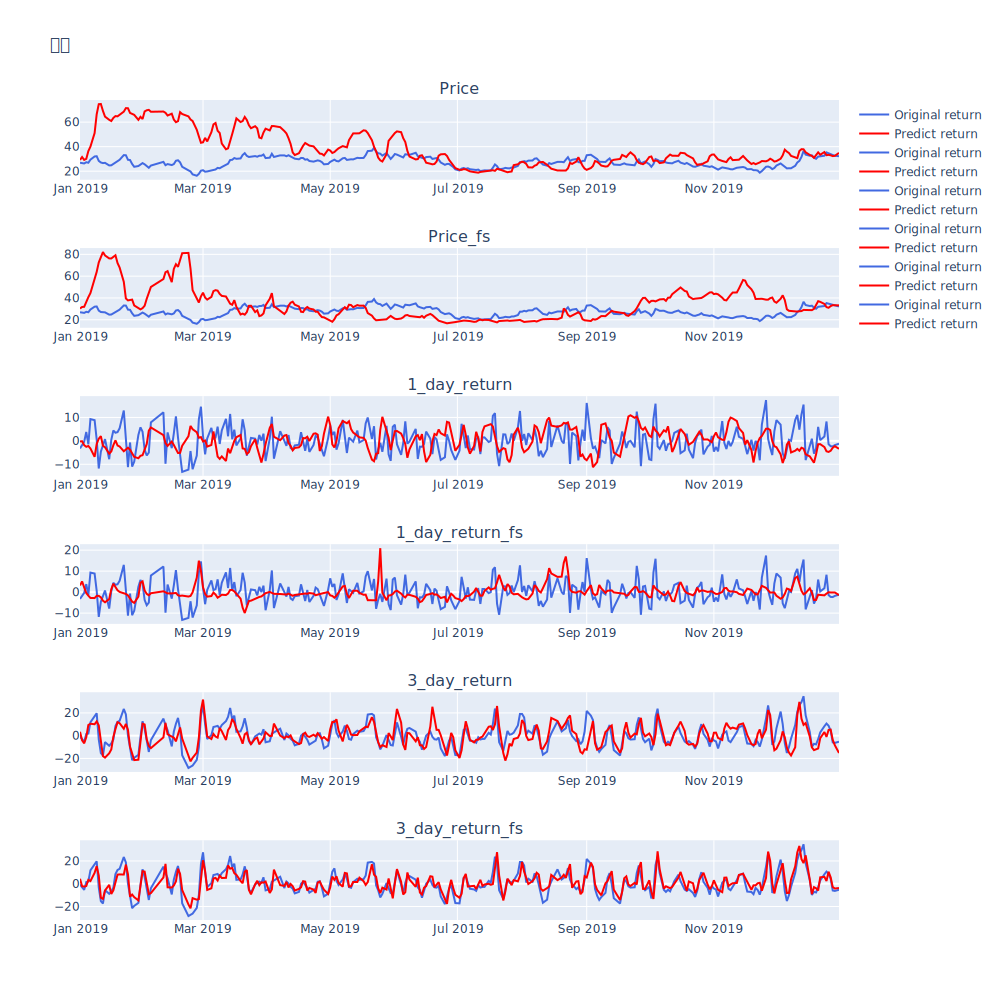

洋香瓜-網狀紅肉_Price, Loss : 0.005599406685642138, Mean : 8.854694902329218
洋香瓜-網狀紅肉_Price_fs, Loss : 0.007034029494844328, Mean : 10.55219947140233
洋香瓜-網狀紅肉_1_day_return, Loss : 0.002827602648097059, Mean : 13.221220009655214
洋香瓜-網狀紅肉_1_day_return_fs, Loss : 0.0021019212095396357, Mean : 11.438343481644035
洋香瓜-網狀紅肉_3_day_return, Loss : 0.0012387049045464414, Mean : 17.993477064621594
洋香瓜-網狀紅肉_3_day_return_fs, Loss : 0.0012708852415251846, Mean : 16.604534166190145


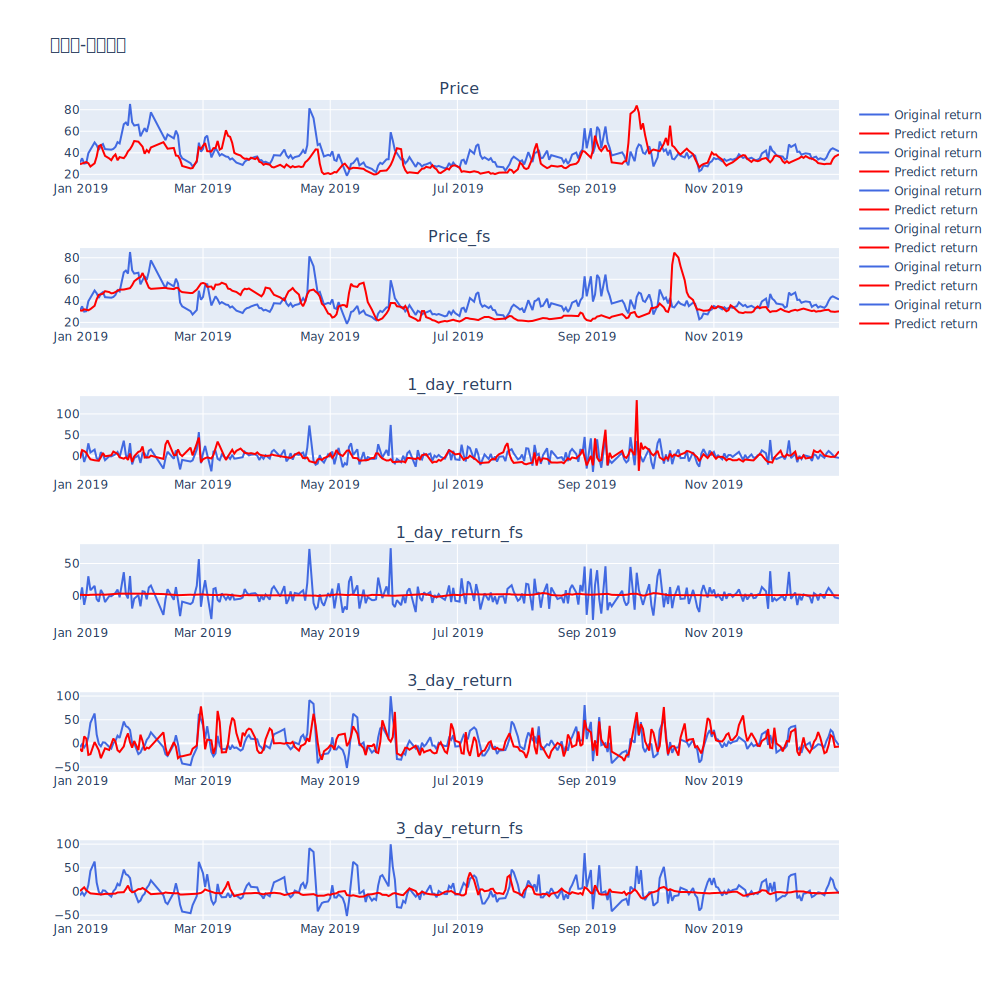

蓮霧-紅蓮霧_Price, Loss : 0.010085134270082185, Mean : 17.705545297405067
蓮霧-紅蓮霧_Price_fs, Loss : 0.02362529497793657, Mean : 26.892689910991077
蓮霧-紅蓮霧_1_day_return, Loss : 0.0016182997953865502, Mean : 9.968333911139913
蓮霧-紅蓮霧_1_day_return_fs, Loss : 0.0016285354562960064, Mean : 9.836444922837176
蓮霧-紅蓮霧_3_day_return, Loss : 0.003210661301526848, Mean : 10.47493228962836
蓮霧-紅蓮霧_3_day_return_fs, Loss : 0.002613471895175042, Mean : 9.849867854032633


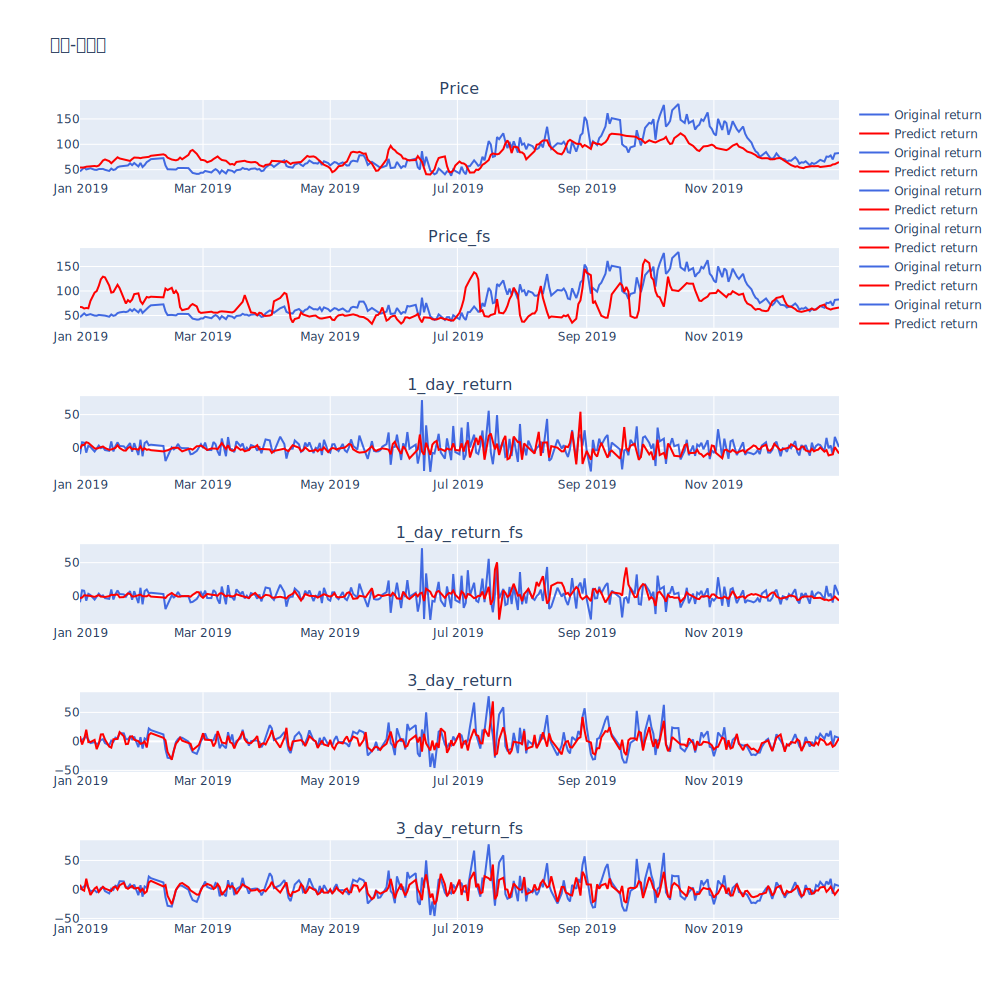

鳳梨-金鑽鳳梨_Price, Loss : 0.021004797199298705, Mean : 4.5251481391115735
鳳梨-金鑽鳳梨_Price_fs, Loss : 0.04066056384390413, Mean : 6.342968727035268
鳳梨-金鑽鳳梨_1_day_return, Loss : 0.013464936329344642, Mean : 9.604130506187213
鳳梨-金鑽鳳梨_1_day_return_fs, Loss : 0.008733423042070606, Mean : 7.4617043195685815
鳳梨-金鑽鳳梨_3_day_return, Loss : 0.01530132962259959, Mean : 10.766562178586778
鳳梨-金鑽鳳梨_3_day_return_fs, Loss : 0.006534562653310622, Mean : 6.685586590134312


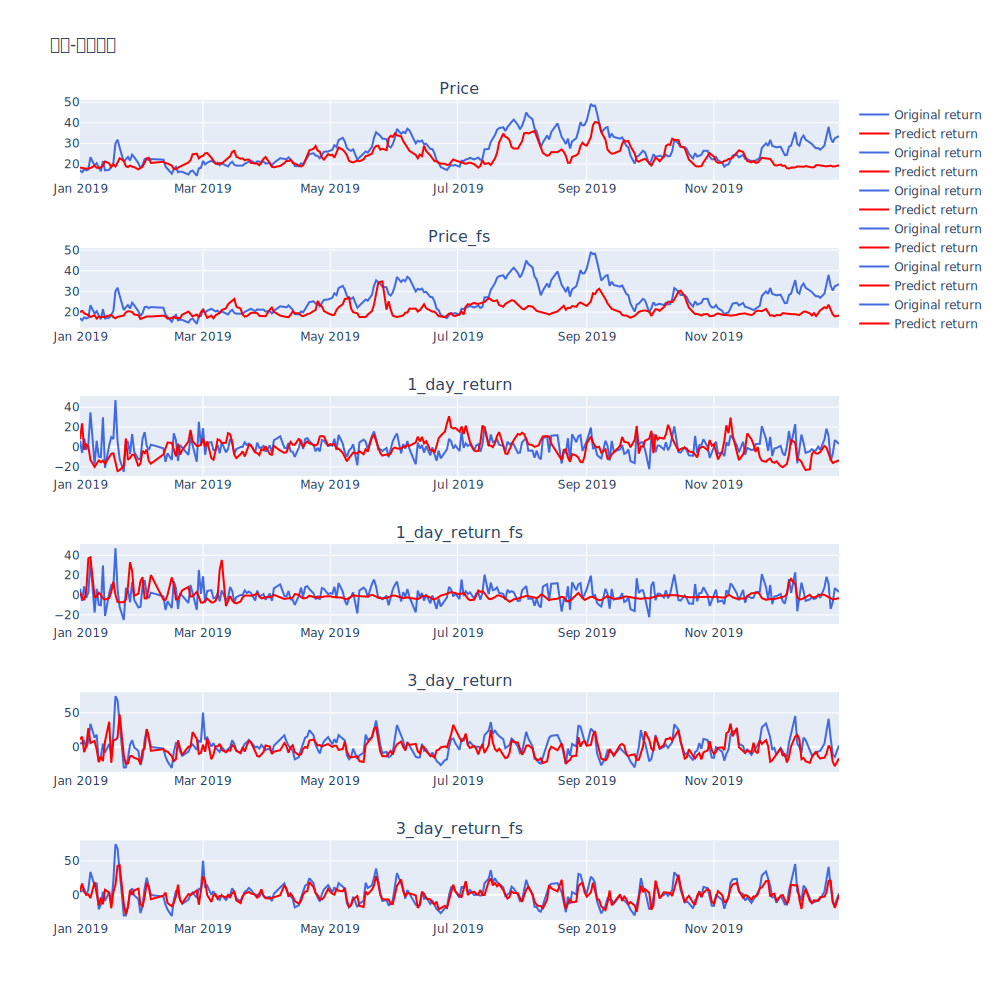

南瓜-木瓜形_Price, Loss : 0.022569476256153256, Mean : 5.9679762868976916
南瓜-木瓜形_Price_fs, Loss : 0.01833024824405693, Mean : 5.805708793971849
南瓜-木瓜形_1_day_return, Loss : 0.0066838468877399295, Mean : 9.650823620685161
南瓜-木瓜形_1_day_return_fs, Loss : 0.003565121078817018, Mean : 7.43615815097968
南瓜-木瓜形_3_day_return, Loss : 0.002497404305666162, Mean : 8.833081863727038
南瓜-木瓜形_3_day_return_fs, Loss : 0.003029708394291733, Mean : 9.671932587648683


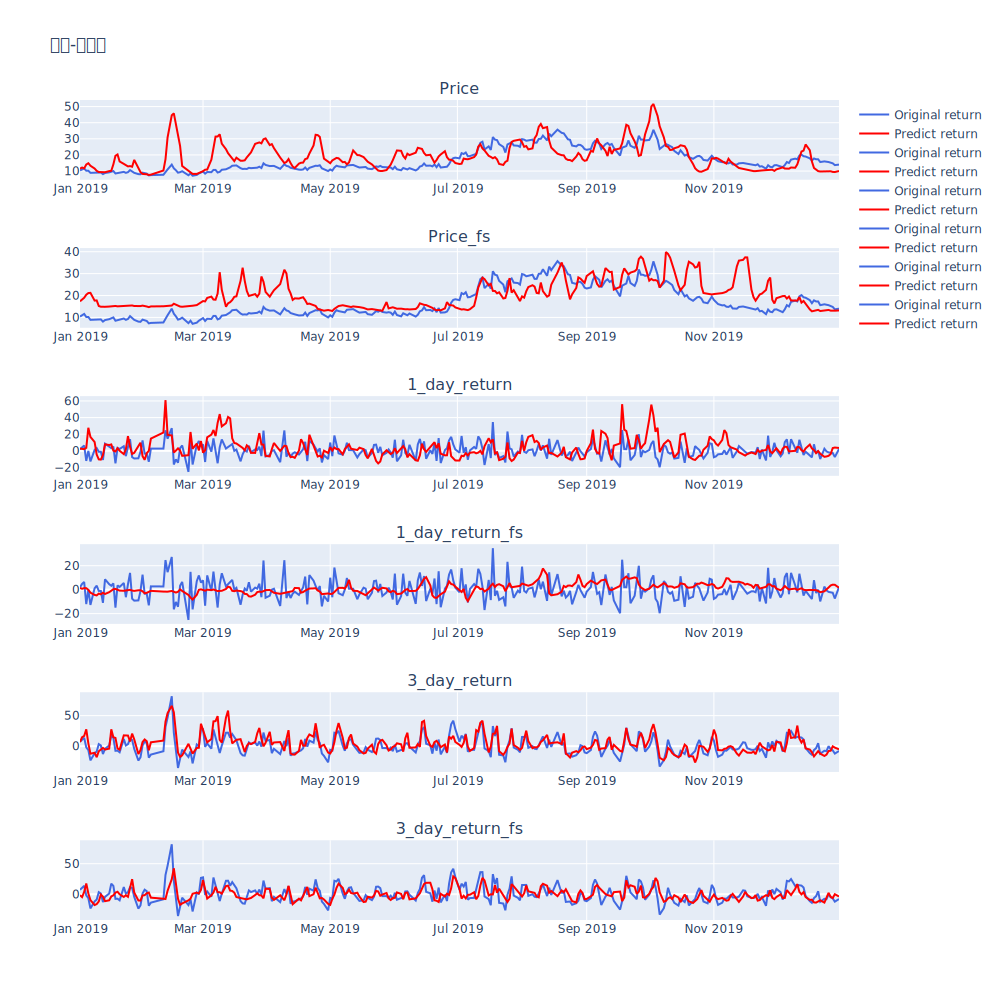

大蒜-蒜仁_Price, Loss : 0.02639135318314469, Mean : 26.971706579835626
大蒜-蒜仁_Price_fs, Loss : 0.03804263457555899, Mean : 31.57782510847053
大蒜-蒜仁_1_day_return, Loss : 0.0010536762564630569, Mean : 1.2071563288460596
大蒜-蒜仁_1_day_return_fs, Loss : 0.0007276228975173361, Mean : 0.7822762055522192
大蒜-蒜仁_3_day_return, Loss : 0.001863064657702992, Mean : 1.7651981021239886
大蒜-蒜仁_3_day_return_fs, Loss : 0.003118682545672277, Mean : 1.5669731547013999


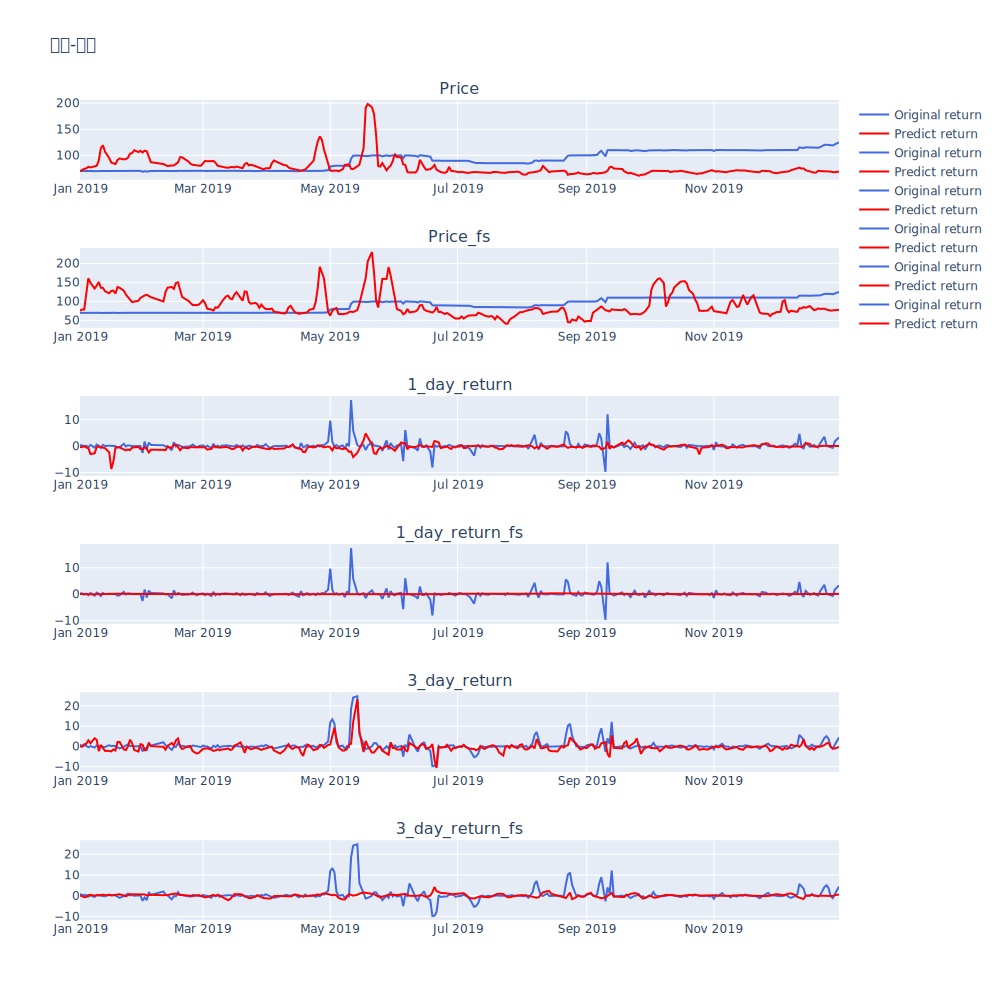

青蔥-日蔥_Price, Loss : 0.07019941407539275, Mean : 66.46075571883082
青蔥-日蔥_Price_fs, Loss : 0.059276900712064276, Mean : 63.95358814507422
青蔥-日蔥_1_day_return, Loss : 0.01844913310941346, Mean : 18.423372280933467
青蔥-日蔥_1_day_return_fs, Loss : 0.00489644379157224, Mean : 10.119954836224426
青蔥-日蔥_3_day_return, Loss : 0.003992474007959101, Mean : 11.923652285071995
青蔥-日蔥_3_day_return_fs, Loss : 0.010596210728819952, Mean : 19.76536323331678


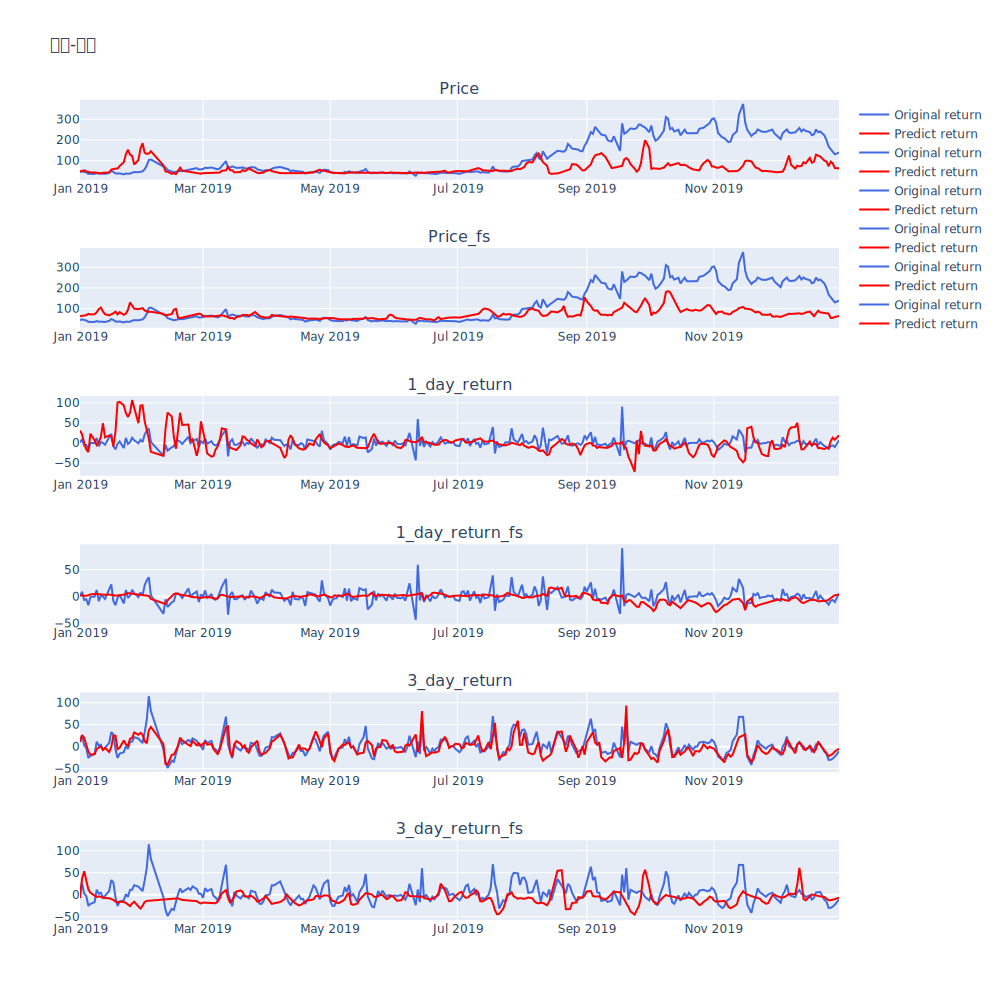

小白菜-土白菜_Price, Loss : 0.0197660016245598, Mean : 9.586665410580844
小白菜-土白菜_Price_fs, Loss : 0.04390774804391714, Mean : 15.620031647698138
小白菜-土白菜_1_day_return, Loss : 0.01164442299239113, Mean : 17.260903712691775
小白菜-土白菜_1_day_return_fs, Loss : 0.007565236833401299, Mean : 14.259955028980448
小白菜-土白菜_3_day_return, Loss : 0.0036181639147966, Mean : 17.742941157188746
小白菜-土白菜_3_day_return_fs, Loss : 0.0031955904104625397, Mean : 16.444530261143086


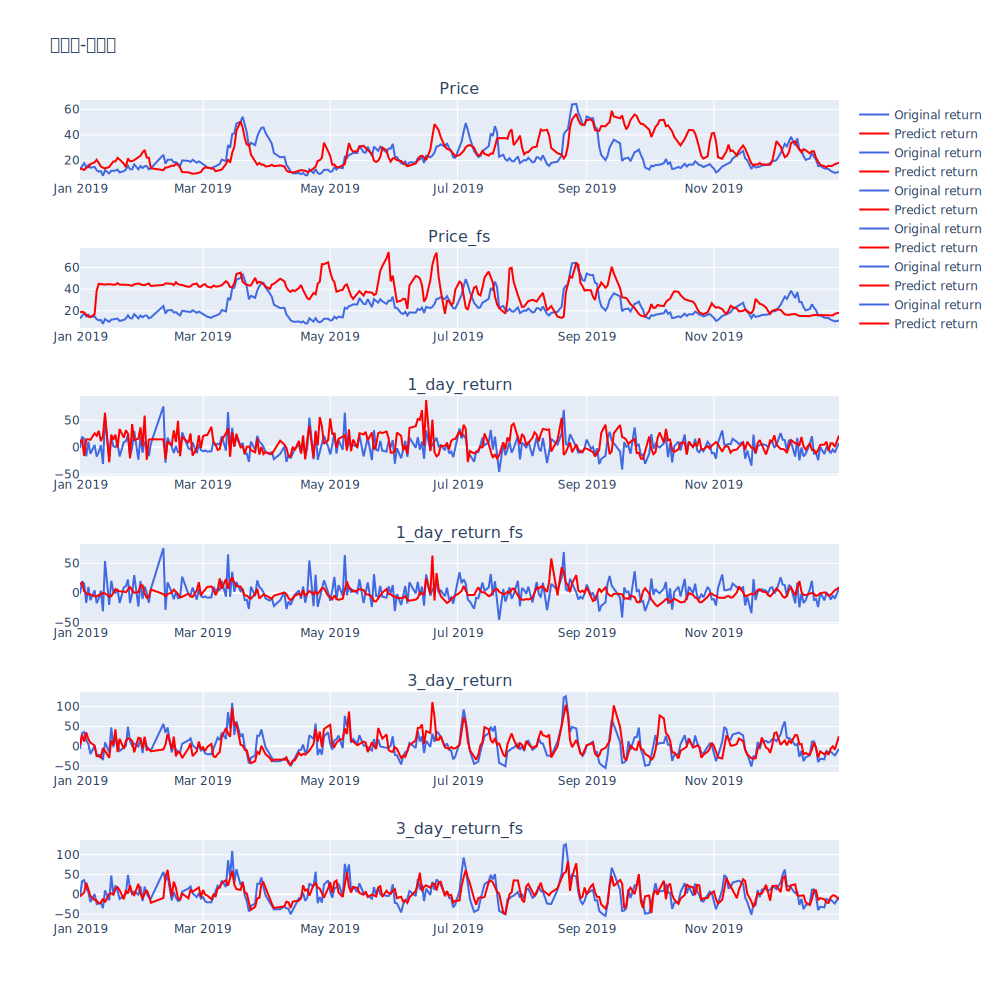

芽菜類-黃豆牙_Price, Loss : 0.00015474493679612473, Mean : 0.3360482533772786
芽菜類-黃豆牙_Price_fs, Loss : 0.0006593316138360605, Mean : 0.8416475764830094
芽菜類-黃豆牙_1_day_return, Loss : 0.0001583843014159111, Mean : 2.0402634239318393
芽菜類-黃豆牙_1_day_return_fs, Loss : 1.1042125344939643e-05, Mean : 0.4096977371910816
芽菜類-黃豆牙_3_day_return, Loss : 0.00020572592199369266, Mean : 2.3182102985626485
芽菜類-黃豆牙_3_day_return_fs, Loss : 8.246137903452936e-05, Mean : 1.1790855549497494


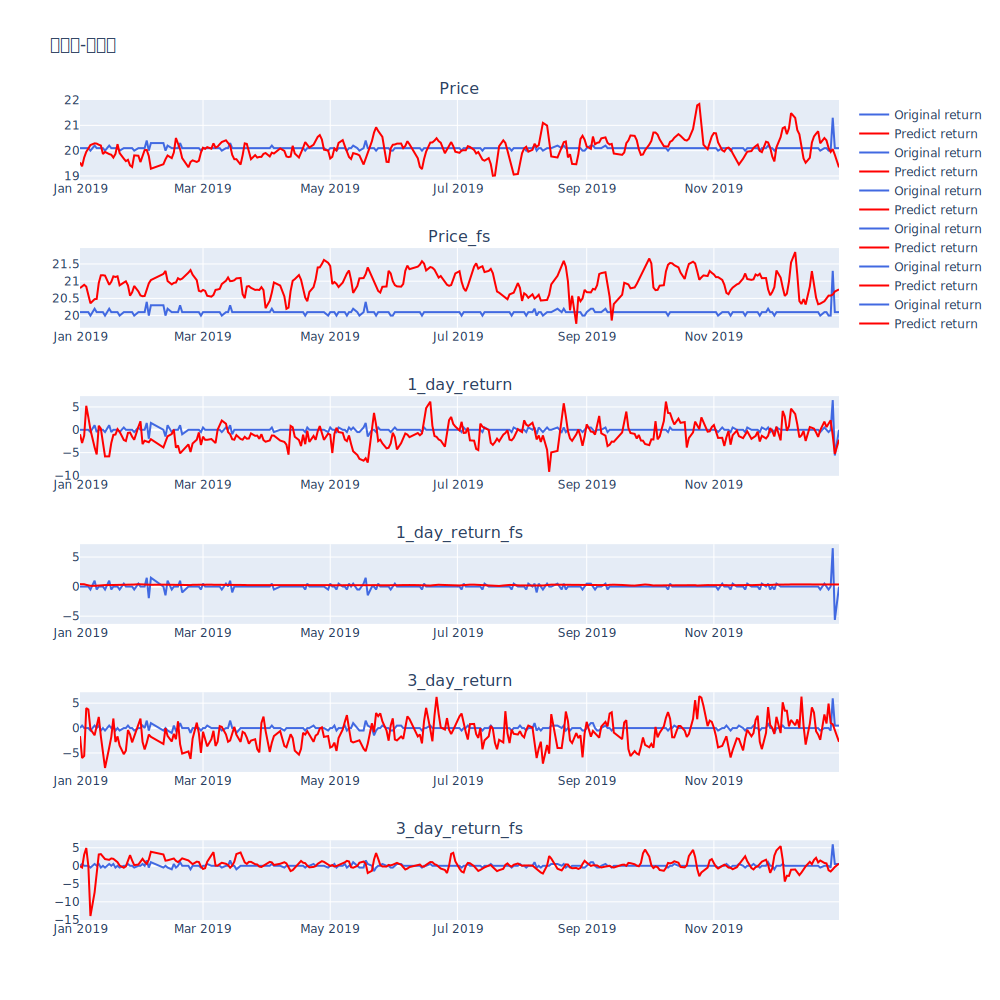

木瓜-網室紅肉_Price, Loss : 0.0071388616952359875, Mean : 5.442405416176072
木瓜-網室紅肉_Price_fs, Loss : 0.00921896205947152, Mean : 6.0565838217336605
木瓜-網室紅肉_1_day_return, Loss : 0.013406461206760045, Mean : 10.870520136439
木瓜-網室紅肉_1_day_return_fs, Loss : 0.012227316434108916, Mean : 9.431763815737533
木瓜-網室紅肉_3_day_return, Loss : 0.006607263192478381, Mean : 10.715200347497145
木瓜-網室紅肉_3_day_return_fs, Loss : 0.017412030701073864, Mean : 16.75934653107871


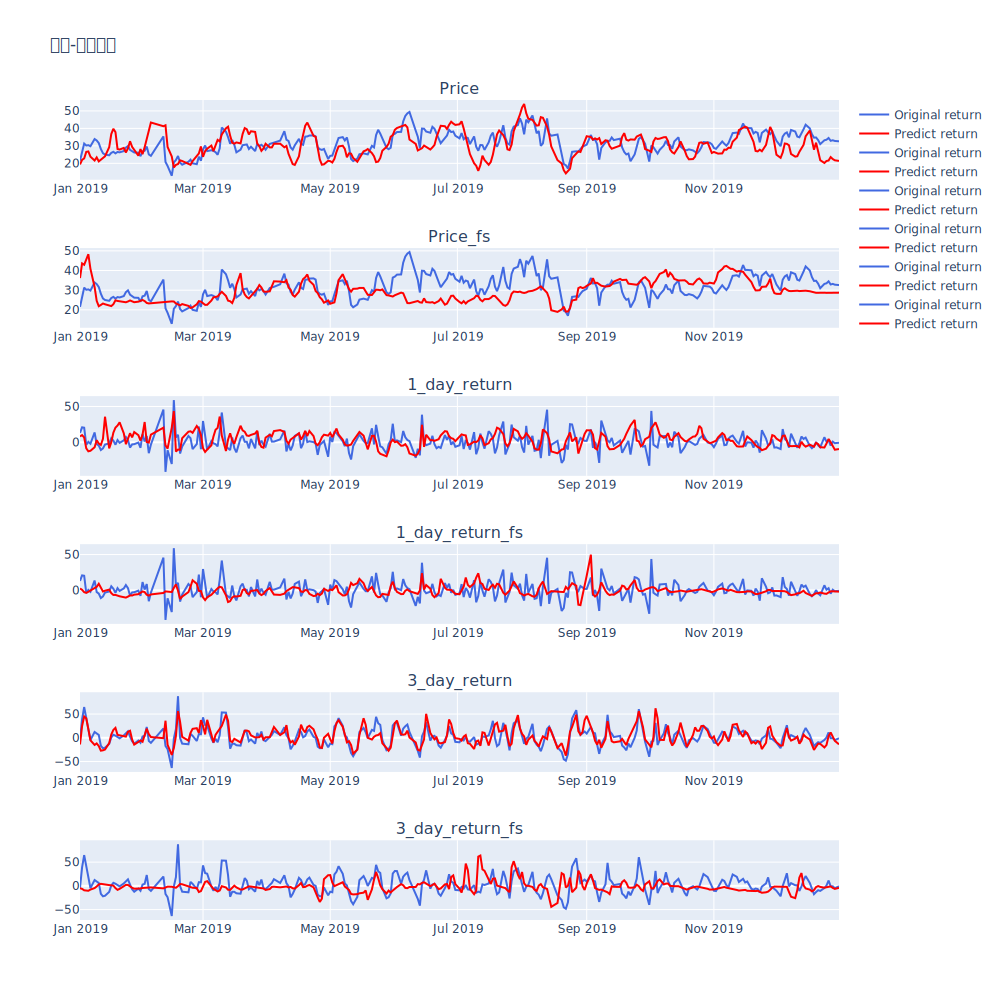

In [16]:
for crops in crops_arr:
    plot_chart_all(crops)